# NCorr-FP scheme run demo - Example with correlated continuous data

* [1. Insetion algorithm (fingerprint embedding)](#insertion)
    * [Step 1](#i-step-1) - an example of mark=0
    * [Step 2](#i-step-2) - an example of mark=1
    * [Step 3](#i-step-3) - an example of marking an attribute with missing values
    * ...
* [2. Detection algorithm](#detection)
    * [Step 1](#d-step-1)
    * [Step 2](#d-step-2)
    * [Step 3](#d-step-3)
    * [Step 50 to end](#d-step-50)

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.stats import gaussian_kde
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

In [2]:
from NCorrFP_scheme.NCorrFP import NCorrFP, sample_from_area

In [3]:
# original data
data = "NCorrFP_scheme/test/test_data/synthetic_300_3_continuous.csv"
dataset = pd.read_csv(data)
correlated_attributes = ['X', 'Y']
dataset.head(5)

,Id,X,Y,Z
0,0,51,42,29
1,1,46,29,22
2,2,60,44,28
3,3,68,52,39
4,4,48,35,25


In [4]:
# fingerprinting 
scheme = NCorrFP(gamma=1, fingerprint_bit_length=16, k=10)
fingerprinted_data, iter_log = scheme.demo_insertion(data, primary_key_name='Id', secret_key=101, recipient_id=4,
                                              correlated_attributes=correlated_attributes)

Start the demo NCorr fingerprint insertion algorithm...
	gamma: 1
	correlated attributes: ['X', 'Y']

Generated fingerprint for recipient 4: 0100000001100100

Generated fingerprint for recipient 4: 0100000001100100
Inserting the fingerprint...

Training balltrees in: 0.01 sec.
Fingerprint inserted.
Runtime: 1.31 sec.


In [5]:
fingerprint = [0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0]

## 1. Insertion algorithm (embedding) <a class="anchor" id="insertion"></a>
The insertion algorithm takes as input:
- dataset
- owner's secret key, recipient ID
- fingerprint length, marking ratio gamma
- list of correlated attributes
- whether the neighbourhood search is distance based (_d_ -- max distance) or cardinality based (_k_ -- minimum cardinality of the neighbourhood)

### Step 1: <a class="anchor" id="i-step-1"></a>
The marking position  (row, attribute) are chosen pseudorandomly seeded by the owner's secret key
#### Marking position: 
- Marking row: 0
- Marking attribute: "_Y_"
- Original value: 42

In [61]:
print("Marking record no. " + str(iter_log[0]['row_index'])) # --> 0
print("Marking attribute: " + str(iter_log[0]['attribute'])) # --> Y
dataset.iloc[[0]]

Marking record no. 0
Marking attribute: Y


,Id,X,Y,Z
0,0,51,42,29


#### Neighbourhood: 
We are looking now in the neighbourhood of the attribute X correlated to Y, the one we are marking. Now the neighbourhood should be the records where X is the closest to 51. 

In [62]:
print('Neighbours idx: ' + str(iter_log[0]['neighbors']))
print('Neighbours dist: ' + str(iter_log[0]['dist']))
print('Neighbours values:' + str(list(dataset.iloc[iter_log[0]['neighbors']]['X'])))

Neighbours idx: [0, 186, 249, 197, 207, 21, 143, 107, 11, 159]
Neighbours dist: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neighbours values:[51, 51, 51, 51, 51, 51, 51, 51, 51, 51]


To sum up:
- Correlated attributes: _X, Y_
- Neighbourhood size: 10
- Max distance (minkowski): 9

Now we look into values of Y, the attribute we are marking, in the neighbourhood, to decide on a new one.

In [64]:
print('Target values:' + str(list(dataset.iloc[iter_log[0]['neighbors']]['Y'])))

Target values:[42, 42, 35, 39, 36, 36, 36, 45, 31, 43]


Let's plot the distribution of the X variable in the neighbourhood.
The mark bit is 0, so we will be sampling the new value from less dense areas.

In [65]:
mark_bit = iter_log[0]['mark_bit']
print(mark_bit)

0


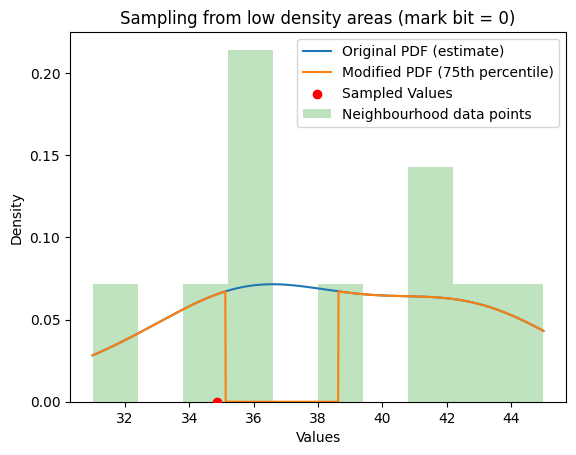

array([34.87518344])

In [66]:
sample_from_area(data=list(dataset.iloc[iter_log[0]['neighbors']]['Y']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[0]['seed'])

#### Marking:

The goal is to modify its value to something that is _likely_ to occur. To introduce pseudorandomness, we obtain _mark bit_ from PRNG based on which there are two outcomes:
- _mark bit is 1_ (50%) -- the new value is sampled from the most dense areas of a distribution of the target variable in the neighbourhood
- _mark bit is 0_ (50%) -- the new value is sampled from the tails of distribution of the target value in the neighbourhood

We used Gaussian Kernel estimaton method to estimate the distribution of the values in the neighbourhood. Once we do that, we cut of an arbitrary percentile (e.g. 75th) and sample from the tails of the distribution since the mark bit was 0.
If the mark bit was 1, we would have sampled from the dense areas of the distribution (we will see that in the following iterations).
The sampled value is rounded to the closest existing from the neighbourhood (to avoid perceptibility of marks in the fingerprinted data).
The final chosen value for attribute Y of record 0 is 35.

In [69]:
iter_log[0]['new_value']

35

In [71]:
fingerprinted_data.head(1)  # --> fingerprinted record

,Id,X,Y,Z
0,0,51,35,29


### Step 2: <a class="anchor" id="i-step-2"></a>
#### Marking position: 

In [73]:
print("Marking record no. " + str(iter_log[1]['row_index'])) # --> 1
print("Marking attribute: " + str(iter_log[1]['attribute'])) # --> Z
dataset.iloc[[1]]

Marking record no. 1
Marking attribute: Z


,Id,X,Y,Z
1,1,46,29,22


Attribute Z is not correlated to the others, so we will use all other attributes to find the closest neighbours and choose a new value, to still preseve the integrity of the dataset.

In [74]:
print('Neighbours idx: ' + str(iter_log[1]['neighbors']))
print('Neighbours dist: ' + str(iter_log[1]['dist']))
#print('Neighbours values:' + str(list(dataset.iloc[iter_log[1]['neighbors']]['X'])))

Neighbours idx: [240, 188, 104, 45, 52, 56, 60, 102, 123, 163, 182, 196, 221, 224, 236, 230, 255, 23, 286, 90, 144, 198, 218, 85]
Neighbours dist: [0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


Neighbourhood is larger than k=10 because there were multiple neighbours of distance=0.5 so we take them all into account.
The neighbourhood looks as follows:

In [75]:
dataset.iloc[iter_log[1]['neighbors']]

,Id,X,Y,Z
240,240,46,29,20
188,188,50,29,19
104,104,46,26,28
45,45,44,29,16
52,52,48,29,15
56,56,42,29,23
60,60,48,29,26
102,102,47,29,24
123,123,41,29,29
163,163,43,29,12


In [76]:
print('Target values:' + str(list(dataset.iloc[iter_log[1]['neighbors']]['Z'])))

Target values:[20, 19, 28, 16, 15, 23, 26, 24, 29, 12, 18, 21, 22, 31, 21, 23, 28, 14, 19, 27, 25, 30, 24, 17]


In [17]:
mark_bit = iter_log[1]['mark_bit']
print('Mark bit is {}, therefore we sample from tails of distribution of the variable Z in the neighbourhood.'.format(mark_bit))

Mark bit is 0, therefore we sample from tails of distribution of the variable Z in the neighbourhood.


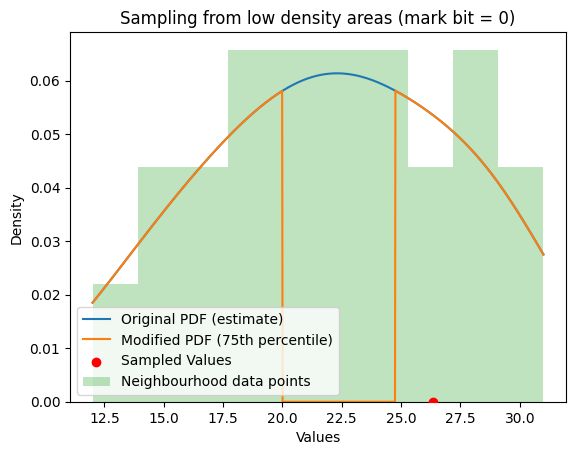

array([26.35653377])

In [18]:
sample_from_area(data=list(dataset.iloc[iter_log[1]['neighbors']]['Z']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[1]['seed'])

In [19]:
iter_log[1]['new_value']

26

In [20]:
fingerprinted_data.iloc[[1]]

,Id,X,Y,Z
1,1,46,29,26


### Step 3: <a class="anchor" id="i-step-3"></a>
#### Marking position: 
- Marking row 2, attribute "Z"

In [77]:
print("Marking record no. " + str(iter_log[2]['row_index'])) # --> 0
print("Marking attribute: " + str(iter_log[2]['attribute'])) # --> Z
dataset.iloc[[2]]

Marking record no. 2
Marking attribute: Z


,Id,X,Y,Z
2,2,60,44,28


#### Neighbourhood: 
- Correlated attributes: X, Y  (we are marking Z, so checking all attributes to define the neighbourhood)
- Neighbourhood size: 14
- Max distance (minkowski): 0.5

In [78]:
print('Neighbours idx: ' + str(iter_log[2]['neighbors']))
print('Neighbours dist: ' + str(iter_log[2]['dist']))

Neighbours idx: [177, 70, 54, 67, 73, 261, 270, 256, 259, 282, 248, 294, 173, 293]
Neighbours dist: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [23]:
print('Target values:' + str(list(dataset.iloc[iter_log[2]['neighbors']]['Z'])))

Target values:[30, 27, 30, 39, 30, 36, 36, 28, 27, 38, 42, 19, 20, 31]


In [79]:
mark_bit = iter_log[2]['mark_bit']
print('Mark bit is {}, therefore we sample again from tails of distribution of the variable Z in the neighbourhood.'.format(mark_bit))

Mark bit is 0, therefore we sample again from tails of distribution of the variable Z in the neighbourhood.


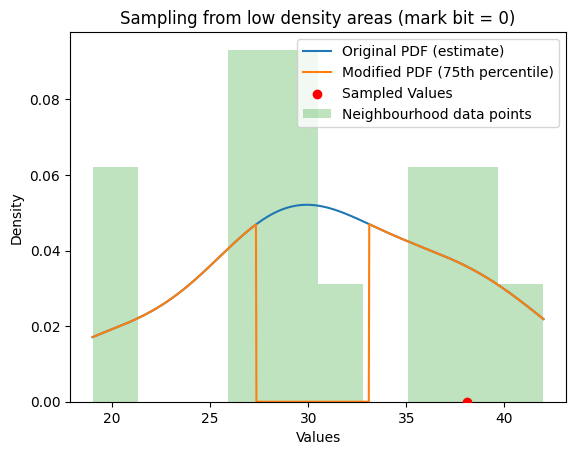

array([38.11573901])

In [25]:
sample_from_area(data=list(dataset.iloc[iter_log[2]['neighbors']]['Z']), percent=0.75, dense=mark_bit, plot=True, 
                 seed=iter_log[2]['seed'])

In [26]:
print(iter_log[2]['new_value'])
fingerprinted_data.iloc[[2]]

38


,Id,X,Y,Z
2,2,60,44,38


### Step 4: <a class="anchor" id="i-step-3"></a>

In [27]:
iter = 3

In [80]:
print("Marking record no. " + str(iter_log[iter]['row_index'])) # --> 3
print("Marking attribute: " + str(iter_log[iter]['attribute'])) # --> X
dataset.iloc[[iter]]

Marking record no. 3
Marking attribute: X


,Id,X,Y,Z
3,3,68,52,39


In [29]:
print('Neighbours idx: ' + str(iter_log[iter]['neighbors']))
print('Neighbours dist: ' + str(iter_log[iter]['dist']))

Neighbours idx: [222, 156, 284, 234, 225, 67, 113, 220, 54, 125, 138, 212]
Neighbours dist: [1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0]


In [30]:
print('Target values:' + str(list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']])))

Target values:[54, 68, 72, 68, 52, 60, 81, 65, 60, 79, 50, 58]


In [82]:
mark_bit = iter_log[iter]['mark_bit']
print('Mark bit is {}, therefore we finally sample from the dense part of distribution of the variable X in the neighbourhood.'.format(mark_bit))

Mark bit is 1, therefore we finally sample from the dense part of distribution of the variable X in the neighbourhood.


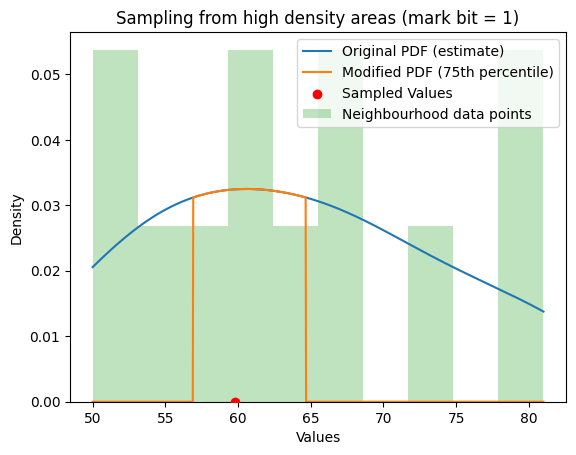

array([59.7599654])

In [32]:
sample_from_area(data=list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']]), percent=0.75, 
                 dense=mark_bit, plot=True, seed=iter_log[iter]['seed'])

In [83]:
print(iter_log[iter]['new_value'])
fingerprinted_data.iloc[[iter]]

60


,Id,X,Y,Z
3,3,60,52,39


## Insertion step for an arbitrary iteration

In [84]:
def show_embedding_iteration(iter):
    print("Marking record no. " + str(iter_log[iter]['row_index'])) 
    print("Marking attribute: " + str(iter_log[iter]['attribute'])) 
    print("The record to mark: \n" + str(dataset.iloc[[iter]]))
    print('------------------------------------------------------------------------------------------------------------------')
    if iter_log[iter]['attribute'] in correlated_attributes:
        other = list(correlated_attributes); other.remove(iter_log[iter]['attribute'])
        print('Neighbourhood: ' +str(iter_log[iter]['attribute']) + ' is correlated to '+ str(other)+ ' so we are finding the records with most similar values to ' + str(other) + '=' + str(dataset.iloc[iter][other[0]]))
    else: 
        print('Neighbourhood: ' + str(iter_log[iter]['attribute']) + ' is not a correlated attribute, so we are including all attributes to find the closest neighbourhood.')
    print('Neighbours idx: ' + str(iter_log[iter]['neighbors']))
    print('Neighbours dist: ' + str(iter_log[iter]['dist']))
    print('Neighbours values:' + str(list(dataset.iloc[iter_log[iter]['neighbors']]['X'])))  
    print('\nNow we look at the values of attribute ' + str(iter_log[iter]['attribute']) + ' in this neighbourhood, and among these is our potential new value.')
    print('Target values:' + str(list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']])))
    print('For this we estimate the distribution of these target values (see the plot below) before sampling one new value.')
    print('There are generally two outcomes for the sampled value:\n\t-mark bit is 1 (50%) - the new value is sampled from the most dense areas of a distribution of the target variable in the neighbourhood\n\t-mark bit is 0(50%) - the new value is sampled from the tails of distribution of the target value in the neighbourhood')
    print('Mark bit is generated pseudorandomly via PRNG.\n')
    mark_bit = iter_log[iter]['mark_bit']
    if mark_bit == 1:
        print('In this case, mark bit is {}, therefore we sample from the dense part of distribution of the variable {} in the neighbourhood. The thresholds are set by an arbitrary percentile (here we use 75th)'.format(mark_bit, iter_log[iter]['attribute']))
    else:
        print('In this case, mark bit is {}, therefore we sample from tails of distribution of the variable {} in the neighbourhood. The thresholds are set by an arbitrary percentile (here we use 75th)'.format(mark_bit, iter_log[iter]['attribute']))
    sample_from_area(data=list(dataset.iloc[iter_log[iter]['neighbors']][iter_log[iter]['attribute']]), percent=0.75, 
                 dense=mark_bit, plot=True, seed=iter_log[iter]['seed'])
    print("The sampled continuous value is rounded to the closest existing value from the data (to avoid perceptibility of marks) and is: " + str(iter_log[iter]['new_value']))
    print("The fingerprinted record is:")
    print(fingerprinted_data.iloc[[iter]])

Marking record no. 202
Marking attribute: Y
The record to mark: 
      Id   X   Y   Z
202  202  54  43  41
------------------------------------------------------------------------------------------------------------------
Neighbourhood: Y is correlated to ['X'] so we are finding the records with most similar values to ['X']=54
Neighbours idx: [99, 140, 82, 202, 9, 75, 47, 51, 68, 55, 70]
Neighbours dist: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neighbours values:[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54]

Now we look at the values of attribute Y in this neighbourhood, and among these is our potential new value.
Target values:[32, 27, 43, 43, 46, 37, 42, 38, 24, 42, 44]
For this we estimate the distribution of these target values (see the plot below) before sampling one new value.
There are generally two outcomes for the sampled value:
	-mark bit is 1 (50%) - the new value is sampled from the most dense areas of a distribution of the target variable in the neighbourhood

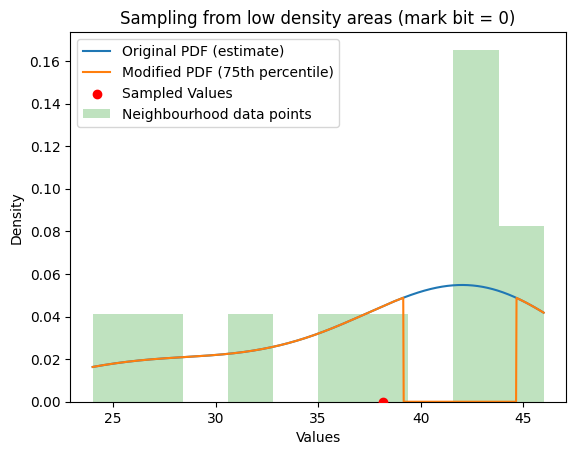

The sampled continuous value is rounded to the closest existing value from the data (to avoid perceptibility of marks) and is: 38
The fingerprinted record is:
      Id   X   Y   Z
202  202  54  38  41


In [85]:
show_embedding_iteration(202)

## 2. Detection Algorithm <a class="anchor" id="detection"></a>
Detection algorithm takes as input the fingerpirnted dataset and following parameters:
- owner's secret key
- gamma (original ratio of marked rows), length of the fingerprint
- a list of marked attribute names
- a list of correlated attributes
- whether the algorithm is distance based (_d_ -- max distance for the neighbourhood) or cardinality based (_k_ -- min cardinality of the neighbourhood)

In [36]:
fingerprinted_data.head(10)

,Id,X,Y,Z
0,0,51,35,29
1,1,46,29,26
2,2,60,44,38
3,3,60,52,39
4,4,48,32,25
5,5,51,43,24
6,6,51,42,26
7,7,55,34,18
8,8,48,29,26
9,9,59,46,39


In [37]:
# 1st position where the mark -should- be
suspect, det_iter_log = scheme.demo_detection(fingerprinted_data, secret_key=101, primary_key='Id',
                               correlated_attributes=correlated_attributes,
                               original_columns=["X", "Y", "Z"])

Start demo NCorr fingerprint detection algorithm ...
	gamma: 1
	correlated attributes: ['X', 'Y']
Training balltrees in: 0.0 sec.
Fingerprint detected: 0100000001100100
Fingerprint belongs to Recipient 4
Runtime: 1.42 sec.


The detected fingerprint is correct and attributed to the correct recipient, hence, the detection was successful. 


The detection reverses the insertion process. This means that each step from detection should match the respective step from the insertion in terms of choosing the same marking row, attribute, and a fingerprint bit. 
Let's inspect the steps:

### Step 1 <a class="anchor" id="d-step-1"></a>
#### Marking position: 
- Marking row: 0
- Marking attribute: _Y_
- Value at the position: 35

In [38]:
print(det_iter_log[0]['row_index']) # --> 0
print(det_iter_log[0]['attribute']) # --> Y 
fingerprinted_data.iloc[[0]]

0
Y


,Id,X,Y,Z
0,0,51,35,29


In [86]:
fingerprinted_value = fingerprinted_data.iloc[det_iter_log[0]['row_index']][det_iter_log[0]['attribute']]
fingerprinted_value

35

#### Neighbourhood: 
- Correlated attributes: _X, Y_
- Neighbourhood size: 10
- Max distance (minkowski): 7

In [40]:
print("Neighbourhood distances: " + str(det_iter_log[0]['dist']))
print("Neighbourhood idx: " + str(det_iter_log[0]['neighbors']))

Neighbourhood distances: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Neighbourhood idx: [0, 5, 6, 11, 21, 184, 207, 186, 159, 197, 81]


In [41]:
# max(det_iter_log[0]['dist'])
fingerprinted_data.iloc[det_iter_log[0]['neighbors']] 

,Id,X,Y,Z
0,0,51,35,29
5,5,51,43,24
6,6,51,42,26
11,11,51,31,24
21,21,51,31,19
184,184,51,36,26
207,207,51,36,26
186,186,51,36,33
159,159,51,35,26
197,197,51,39,24


In [94]:
target_values_det = list(fingerprinted_data.iloc[det_iter_log[0]['neighbors']][det_iter_log[0]['attribute']])
print('Target values:' + str(target_values_det))

Target values:[35, 43, 42, 31, 31, 36, 36, 36, 35, 39, 32]


We reverse engineer the steps from the embedding, i.e. we estimate the distribution of the target variable and see where the fingerprinted value falls within this distribution. Its position will tell us what the mark bit is.

In [95]:
from scipy.stats import gaussian_kde

def values_for_plot_distribution(target_values):
    data = target_values
    kde = gaussian_kde(data)
    # Create a range of values to evaluate the PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf_values = kde(x)

    threshold = np.percentile(pdf_values, 0.75*100)

    mask = (pdf_values >= threshold)
    # Re-normalize the masked PDF and CDF
    masked_pdf = np.where(mask, pdf_values, 0)
    masked_cdf = np.cumsum(masked_pdf)
    masked_cdf /= masked_cdf[-1]
    
    return x, pdf_values, masked_pdf

In [96]:
x_det, pdf_values_det, masked_pdf_det = values_for_plot_distribution(target_values_det)

In [97]:
target_values_ins = list(dataset.iloc[iter_log[0]['neighbors']][iter_log[0]['attribute']])
x_ins, pdf_values_ins, masked_pdf_ins = values_for_plot_distribution(target_values_ins)

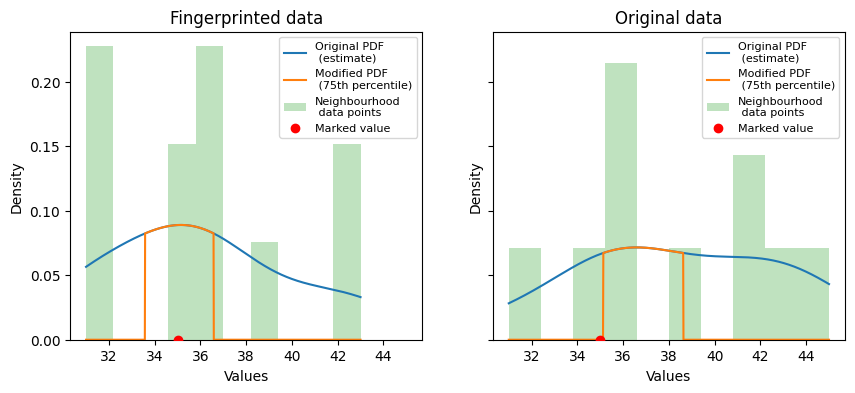

In [98]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,4))

axs[0].plot(x_det, pdf_values_det, label='Original PDF\n (estimate)')
axs[0].plot(x_det, masked_pdf_det, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
axs[0].hist(target_values_det, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
axs[0].scatter(fingerprinted_value, 0, color='red', label='Marked value', zorder=5)
axs[0].set_ylabel('Density')
axs[0].set_xlabel('Values')
axs[0].set_title('Fingerprinted data')
axs[0].legend(prop={'size': 8})

axs[1].plot(x_ins, pdf_values_ins, label='Original PDF\n (estimate)')
axs[1].plot(x_ins, masked_pdf_ins, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
axs[1].hist(target_values_ins, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
axs[1].scatter(iter_log[0]['new_value'], 0, color='red', label='Marked value', zorder=5)
axs[1].set_ylabel('Density')
axs[1].set_xlabel('Values')
axs[1].set_title('Original data')
axs[1].legend(prop={'size': 8})

On the left-hand side, we show the distribution of the neighbourhood in the fingerprinted data obtained during the detection. On the right-hand side we show the distribution of the neighbourhoods of the same record from the original data for comparison.

Note that the neighbourhood for the same record is not the same -- this is because the fingerprint marks disrupt calculating distances from the record in question. If the similar distribution is preserved, the fingerprint marks will be extracted correctly. The detection algorithm makes a decision on the fingerprint mark based on where the observed value falls within the distribution. If the obsrved value
- falls into the dense area within the thresholds, the mark bit is detected as 1
- falls outside of the thresholds into the tails of distribution, the mark bit is detected 0

However, the shift in distribution might mean that _some_ marks are detected wrongly.

#### Detecting the mark:
- Mark bit is in this case be detected 1 --> the fingerprinted value falls within the 75th percentile threshold, hence the mark bit must have been 1 according to the insertion algorithm:  

In [99]:
det_iter_log[0]['mark_bit'] # --> 1

1

In [100]:
print("Detected pseudorandomly in this step:")
print("\t- Mask bit: {} (retrieved pseudorandomly in this step)".format(det_iter_log[0]['mask_bit']))
print("\t- Finterprint bit position (index): {}".format(det_iter_log[0]['fingerprint_idx']))
print("\t- Fingerprint bit value: {} (mark bit xor mask bit))".format(det_iter_log[0]['fingerprint_bit']))

Detected pseudorandomly in this step:
	- Mask bit: 0 (retrieved pseudorandomly in this step)
	- Finterprint bit position (index): 15
	- Fingerprint bit value: 1 (mark bit xor mask bit))


The detection extracted a wrong vote for fingerprint bit at position 15 to be 1 (this does not match with the original fingerprint from embedding).

### Step 2 <a class="anchor" id="d-step-2"></a>
#### Marking position: 
- Marking row: 1
- Marking attribute: _Z_
- Value at the position: 29

In [101]:
print(det_iter_log[1]['row_index']) # --> 0
print(det_iter_log[1]['attribute']) # --> Z
fingerprinted_data.iloc[[1]]

1
Z


,Id,X,Y,Z
1,1,46,29,26


In [102]:
fingerprinted_value = fingerprinted_data.iloc[det_iter_log[1]['row_index']][det_iter_log[1]['attribute']]
fingerprinted_value

26

#### Neighbourhood: 
- Correlated attributes: _X, Y_
- Neighbourhood size: 23
- Max distance (minkowski): 0.5

In [51]:
print("Neighbourhood distances: " + str(det_iter_log[1]['dist']))
print("Neighbourhood idx: " + str(det_iter_log[1]['neighbors']))

Neighbourhood distances: [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Neighbourhood idx: [1, 240, 104, 196, 218, 45, 163, 102, 236, 255, 188, 257, 221, 182, 52, 8, 224, 290, 39, 264, 286, 85, 23]


In [105]:
# max(det_iter_log[1]['dist'])
# fingerprinted_data.iloc[det_iter_log[1]['neighbors']] 
target_values_det = list(fingerprinted_data.iloc[det_iter_log[1]['neighbors']][det_iter_log[1]['attribute']])
print('Target values:' + str(target_values_det))

Target values:[26, 24, 28, 21, 24, 16, 31, 28, 18, 23, 19, 33, 16, 18, 19, 26, 31, 24, 23, 29, 20, 22, 14]


- Distribution in the neighbourhood:

In [106]:
x_det, pdf_values_det, masked_pdf_det = values_for_plot_distribution(target_values_det)

In [107]:
target_values_ins = list(dataset.iloc[iter_log[1]['neighbors']][iter_log[1]['attribute']])
x_ins, pdf_values_ins, masked_pdf_ins = values_for_plot_distribution(target_values_ins)

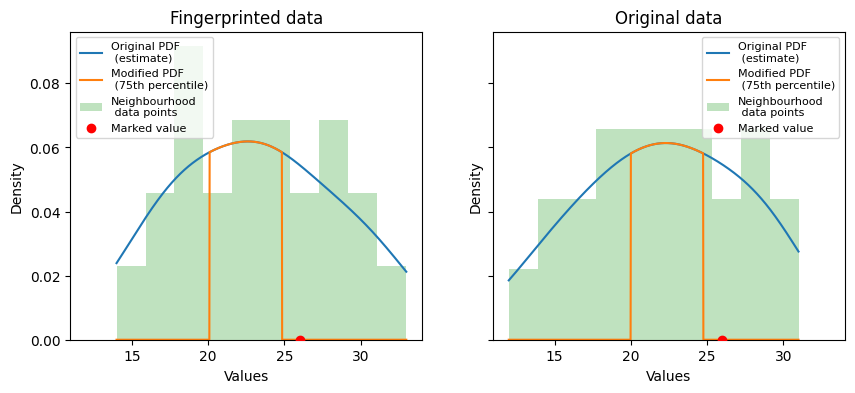

In [108]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,4))

axs[0].plot(x_det, pdf_values_det, label='Original PDF\n (estimate)')
axs[0].plot(x_det, masked_pdf_det, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
axs[0].hist(target_values_det, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
axs[0].scatter(fingerprinted_value, 0, color='red', label='Marked value', zorder=5)
axs[0].set_ylabel('Density')
axs[0].set_xlabel('Values')
axs[0].set_title('Fingerprinted data')
axs[0].legend(prop={'size': 8})

axs[1].plot(x_ins, pdf_values_ins, label='Original PDF\n (estimate)')
axs[1].plot(x_ins, masked_pdf_ins, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
axs[1].hist(target_values_ins, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
axs[1].scatter(iter_log[1]['new_value'], 0, color='red', label='Marked value', zorder=5)
axs[1].set_ylabel('Density')
axs[1].set_xlabel('Values')
axs[1].set_title('Original data')
axs[1].legend(prop={'size': 8})

The distribution is this time closely preserved from the original data, hence no confusion about the marking should be made by the detection algorithm: 

#### Detecting the mark:
- Mark bit: 0 --> the fingerprinted value falls outside of 75th percentile threshold
- Detected pseudorandomly in this step:
    - Mask bit: 0 
    - Finterprint bit position (index): 15
- Fingerprint bit value: 0 (mark bit xor mask bit)

This time, the fingerprint bit is detected correctly.

In [109]:
print(det_iter_log[1]['mark_bit']) # --> 0 (target value comes from the tails of distribution)
print(det_iter_log[1]['mask_bit']) # --> 0 (pseudoranomly from PRNG)
print(det_iter_log[1]['fingerprint_idx']) # --> 15 (from PRNG)
print(det_iter_log[1]['fingerprint_bit']) # --> 0 (mark bit xor mask bit)

# updating the votes for fingerprint 
# Image("NCorrFP_scheme/figures/CorNN-demo-Votes-step2.png")

0
0
15
0


## Detection step for an aribitrary iteration

In [57]:
# for converting fingerprint to color pattern for plotting the count state
def binary_to_pairs(binary_list):
    # Initialize an empty list to store the result
    result = []
    
    # Iterate over each element in the binary list
    for value in binary_list:
        if value == 0:
            # If the input value is 0, create the pair (1, 0)
            pair = (1, 0)
        else:
            # If the input value is 1, create the pair (0, 1)
            pair = (0, 1)
        # Append the pair to the result list
        result.append(pair)
    
    return result

In [58]:
def plot_count_updates(count_state, fingerprint):
    # Extract the first and second values of each pair for the rows
    first_row = [pair[0] for pair in count_state]
    second_row = [pair[1] for pair in count_state]

    # Extract the color flags for each row
    color_flags = binary_to_pairs(fingerprint)  # 1 = green, 0 = red
    first_row_flags = [flag[0] for flag in color_flags]
    second_row_flags = [flag[1] for flag in color_flags]
    
    # Normalize values for color intensity
    all_values = first_row + second_row
    norm = colors.Normalize(vmin=min(all_values), vmax=max(all_values))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(len(count_state), 2))

    # Create the table with two rows (first row, second row)
    table_data = [first_row, second_row]
    table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.05]*len(count_state))

    # Hide the axes
    ax.axis('off')

    # Iterate over the table cells to set the colors based on value and color flag
    for i in range(2):  # Two rows
        for j in range(len(count_state)):
            # Get the value for the cell
            value = table_data[i][j]
            
            # Determine the color based on the color flags
            if i == 0:  # First row
                if first_row_flags[j] == 1:
                    color = plt.cm.Greens(norm(value))  # Green colormap if flag is 1
                else:
                    color = plt.cm.Reds(norm(value))  # Red colormap if flag is 0
            else:  # Second row
                if second_row_flags[j] == 1:
                    color = plt.cm.Greens(norm(value))  # Green colormap if flag is 1
                else:
                    color = plt.cm.Reds(norm(value))  # Red colormap if flag is 0

            # Set the color of the cell
            cell = table[(i, j)]
            cell.set_facecolor(color)
            cell.set_text_props(color='black')

    # Display the plot
    plt.show()

In [59]:
def show_detection_iteration(iteration):
    print("Detecting from record at idx: " + str(det_iter_log[iteration]['row_index']))
    print("Detecting from attribute: " + str(det_iter_log[iteration]['attribute']) )
    print(fingerprinted_data.iloc[[iteration]])
    fingerprinted_value = fingerprinted_data.iloc[det_iter_log[iteration]['row_index']][det_iter_log[iteration]['attribute']]
    print('Fingerpritned value: ' + str(fingerprinted_value))
    target_values_det = fingerprinted_data.iloc[det_iter_log[iteration]['neighbors']][det_iter_log[iteration]['attribute']].tolist()
    print("----------------------------------------------------------")
    print("Obtaining neighbourhood....")
    print('Target values:' + str(target_values_det))
    print("----------------------------------------------------------")

    x_det, pdf_values_det, masked_pdf_det = values_for_plot_distribution(target_values_det)
    target_values_ins = list(dataset.iloc[iter_log[iteration]['neighbors']][iter_log[iteration]['attribute']])
    x_ins, pdf_values_ins, masked_pdf_ins = values_for_plot_distribution(target_values_ins)
    
    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,4))

    axs[0].plot(x_det, pdf_values_det, label='Original PDF\n (estimate)')
    axs[0].plot(x_det, masked_pdf_det, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
    axs[0].hist(target_values_det, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
    axs[0].scatter(fingerprinted_value, 0, color='red', label='Marked value', zorder=5)
    axs[0].set_ylabel('Density')
    axs[0].set_xlabel('Values')
    axs[0].set_title('Fingerprinted data')
    axs[0].legend(prop={'size': 8})

    axs[1].plot(x_ins, pdf_values_ins, label='Original PDF\n (estimate)')
    axs[1].plot(x_ins, masked_pdf_ins, label='Modified PDF\n ({}th percentile)'.format(int(100*0.75)))
    axs[1].hist(target_values_ins, bins=10, density=True, alpha=0.3, label='Neighbourhood\n data points')
    axs[1].scatter(iter_log[iteration]['new_value'], 0, color='red', label='Marked value', zorder=5)
    axs[1].set_ylabel('Density')
    axs[1].set_xlabel('Values')
    axs[1].set_title('Original data')
    axs[1].legend(prop={'size': 8})
    
    print("\n--> Observing the distribution of target attribute {} below...".format(det_iter_log[iteration]['attribute']))
    message = ' (i.e. tails of distribution)' if det_iter_log[iteration]['mark_bit']==0 else ' (i.e. in densest area)'
    print("Mark bit (where in distribution falls the target value?): " + str(det_iter_log[iteration]['mark_bit']) + message)
    print("Mask bit (from PRNG): " + str(det_iter_log[iteration]['mask_bit']))
    print("Fingerprint bit index (from PRNG): " + str(det_iter_log[iteration]['fingerprint_idx']))
    print("Fingerprint bit value (mark bit xor mask bit): " + str(det_iter_log[iteration]['fingerprint_bit']))
    
    if det_iter_log[iteration]['fingerprint_bit'] == fingerprint[det_iter_log[iteration]['fingerprint_idx']]:
        print('\nFingerprint bit CORRECT :)')
    else:
        print('\nFingerprint bit FALSE :( (it is just a wrong vote)')
    
    plot_count_updates(det_iter_log[iteration]['count_state'], fingerprint)
    print('Table: fingerprint count updates after this iteration (iteration {}). Each column is one fingerprint bit position (e.g. 16-bit --> 16 columns), and each row represents votes for either 0 or 1 being the value of that bit. The final decision is made at the end af the detection algorithm according to majority vote.'.format(iteration))

Detecting from record at idx: 299
Detecting from attribute: Y
      Id   X   Y   Z
299  299  58  49  35
Fingerpritned value: 49
----------------------------------------------------------
Obtaining neighbourhood....
Target values:[37, 55, 31, 49, 49, 37, 56, 39, 42, 42, 30]
----------------------------------------------------------

--> Observing the distribution of target attribute Y below...
Mark bit (where in distribution falls the target value?): 0 (i.e. tails of distribution)
Mask bit (from PRNG): 0
Fingerprint bit index (from PRNG): 8
Fingerprint bit value (mark bit xor mask bit): 0

Fingerprint bit CORRECT :)


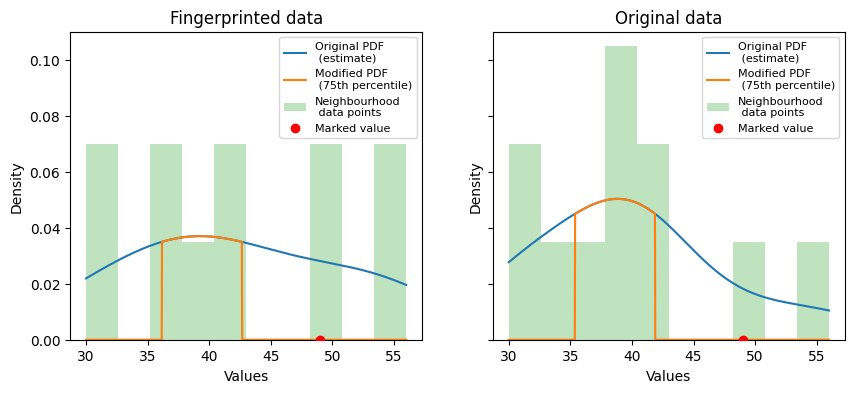

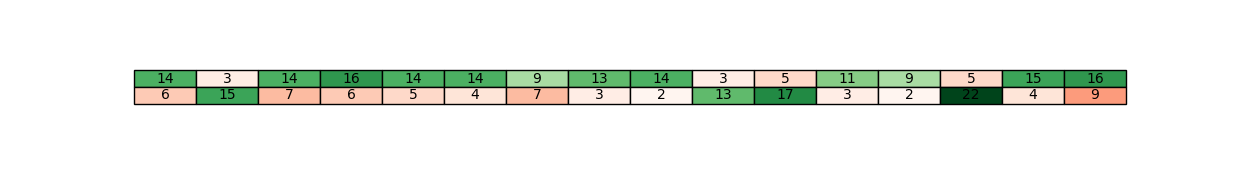

Table: fingerprint count updates after this iteration (iteration -1). Each column is one fingerprint bit position (e.g. 16-bit --> 16 columns), and each row represents votes for either 0 or 1 being the value of that bit. The final decision is made at the end af the detection algorithm according to majority vote.


In [111]:
show_detection_iteration(-1)